In [6]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose 
import statsmodels.tsa.stattools as sts 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from pmdarima.arima import auto_arima
import seaborn as sns

sns.set_style("darkgrid")
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

In [7]:
### Function to convert dataframe to timeseries object
def create_ts_object(df):
    df.Timestamp = pd.to_datetime(df.Timestamp)
    df.set_index("Timestamp", inplace=True)
    df = df.asfreq('H')

    return df.head()

### Import Digester 18 data

In [8]:
data18 = pd.read_csv("~/Documents/Data/FinalDatasetForModel/Digester18data.csv")
data18.drop(['Dig_18_woodload', 'Dig_18_Liq_circ',
       'Digester_18_temperature', 'Digester_18_pressure',
       'Dig_18_phase_Comm Fail', 'Dig_18_phase_Configure',
       'Dig_18_phase_HP GAS RELEASE', 'Dig_18_phase_LIQUOR LOADING',
       'Dig_18_phase_LP GAS RELEASE', 'Dig_18_phase_PULP DISCHARGE',
       'Dig_18_phase_READY FOR LIQUOR',
       'Dig_18_phase_READY FOR PULP DISCH',
       'Dig_18_phase_READY FOR STEAMING', 'Dig_18_phase_READY FOR WOOD',
       'Dig_18_phase_SFACTOR TGT REACHED',
       'Dig_18_phase_SMOOTH STEAM FIXED',
       'Dig_18_phase_SMOOTH STEAM RAMP', 'Dig_18_phase_Scan Timeout',
       'Dig_18_phase_TEMP RAMP TO 110C', 'Dig_18_phase_TEMP RAMP TO 126C',
       'Dig_18_phase_TEMP RAMP TO TMAX', 'Dig_18_phase_VALVE CHECK',
       'Dig_18_phase_WOODLOAD COMPLETE', 'Dig_18_phase_WOODLOADING', 'Dig_18_phase_PULP DISCH COMPLETE'], axis = 1, inplace=True)

create_ts_object(data18)

,Dig_18_HX
Timestamp,
2020-11-01 00:00:00,1.219151
2020-11-01 01:00:00,0.066844
2020-11-01 02:00:00,0.016664
2020-11-01 03:00:00,0.048368
2020-11-01 04:00:00,0.080073


### Stationarity

In [9]:
sts.adfuller(data18.Dig_18_HX)

(-7.922567459538152,
 3.690666621139681e-12,
 18,
 2190,
 {'1%': -3.43333948922474,
  '5%': -2.8628606583021843,
  '10%': -2.5674730514376263},
 11100.86829822254)

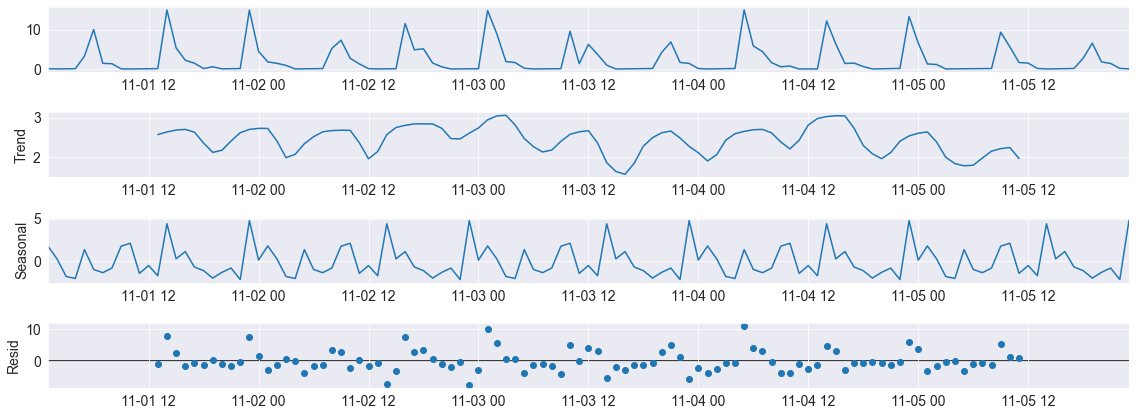

In [10]:
seas_dec = seasonal_decompose(data18[1:120], model = "additive")
seas_dec.plot()
plt.show()

### ACF

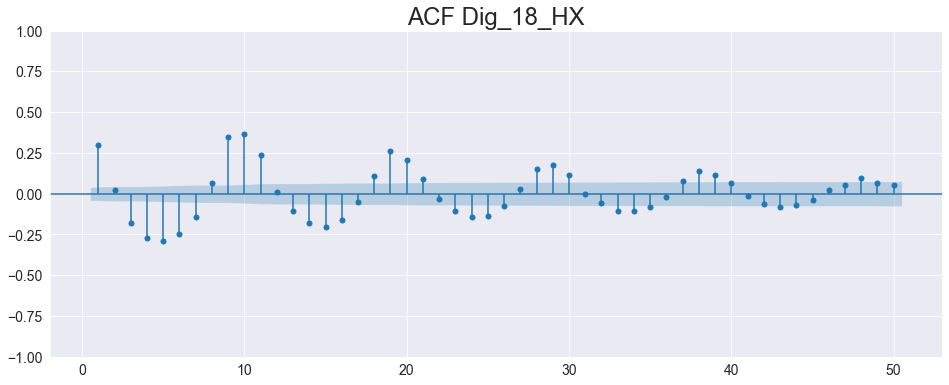

In [11]:
sgt.plot_acf(data18.Dig_18_HX, lags = 50, zero = False)
plt.title("ACF Dig_18_HX", size = 24)
plt.show()

### PACF

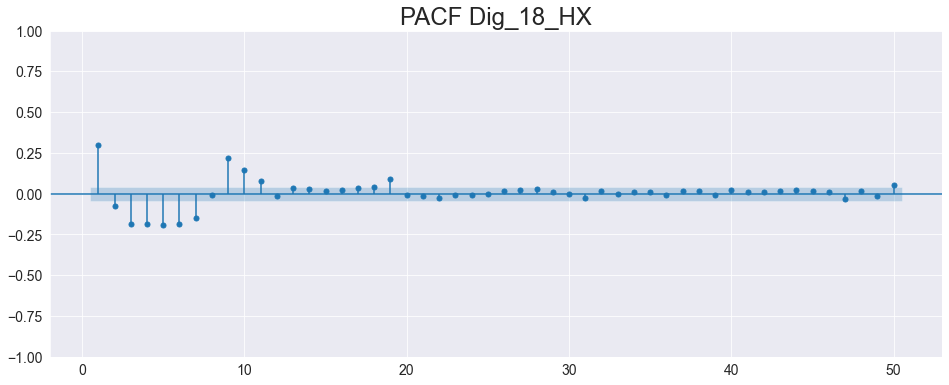

In [12]:
sgt.plot_pacf(data18.Dig_18_HX, lags = 50, zero = False, method = ('ols'))
plt.title("PACF Dig_18_HX", size = 24)
plt.show()

In [13]:
#  Spare copy
data18_twin1 = data18.copy()

### Normalization

In [14]:
# define functions to scale and reverse-scale data, looping through the columns, and passing a scaler type
def scale_data(data, scaler):
    for col in data.columns.values:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
    return data.head()

In [15]:
scaler = MinMaxScaler()
data18_twin = data18.copy()
scale_data(data18_twin, scaler)

,Dig_18_HX
Timestamp,
2020-11-01 00:00:00,0.081277
2020-11-01 01:00:00,0.004456
2020-11-01 02:00:00,0.001111
2020-11-01 03:00:00,0.003225
2020-11-01 04:00:00,0.005338


### Data Split

In [16]:
train_size = int(len(data18_twin)*0.85)
val_size = train_size + int(len(data18_twin)*0.10)
train_data18 = data18_twin.iloc[:train_size]
val_data18 = data18_twin.iloc[train_size:val_size]
test_data18 = data18_twin.iloc[val_size:]

In [17]:
val_data18.head()

,Dig_18_HX
Timestamp,
2021-01-18 05:00:00,0.002232
2021-01-18 06:00:00,0.003400
2021-01-18 07:00:00,0.004569
2021-01-18 08:00:00,0.005737
2021-01-18 09:00:00,0.006906


### Auto ARIMA Model

In [18]:
model_auto = auto_arima(train_data18.Dig_18_HX, max_order = None, max_p = 30, max_q = 40, maxiter = 100, alpha = 0.05, n_jobs = -1, trend = 'ct',)

C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


In [19]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1877
Model:               SARIMAX(2, 1, 2)   Log Likelihood                  -3.131
Date:                Sat, 12 Mar 2022   AIC                             20.262
Time:                        12:42:06   BIC                             59.020
Sample:                             0   HQIC                            34.539
                               - 1877                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0008      0.001     -0.557      0.578      -0.003       0.002
drift       4.919e-07    8.2e-07      0.600      0.549   -1.12e-06     2.1e-06
ar.L1         -0.2868      0.095     -3.012      0.003      -0.473      -0.100
ar.L2          0.4939      0.057      8.622      0.000       0.382       0.606
ma.L1         -0.1919      0.093     -2.060      0.039      -0.374      -0.009
ma.L2         -0.7456      0.075     -9.973      0.000      -0.892      -0.599
sigma2         0.0638      0.003     21.171      0.000       0.058       0.070
===================================================================================
Ljung-Box (L1) (Q):                  36.17   Jarque-Bera (JB):              6560.95
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             2.68
Prob(H) (two-sided):                  0.13   Kurtosis:                        10.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMA Model Residual Analysis

In [20]:
data18_resid_dataset = train_data18.copy()
data18_resid_dataset['residuals'] = model_auto.resid()

In [21]:
print(data18_resid_dataset.residuals.mean())
print(data18_resid_dataset.residuals.var())

0.004934305918366362
0.05850576725579575


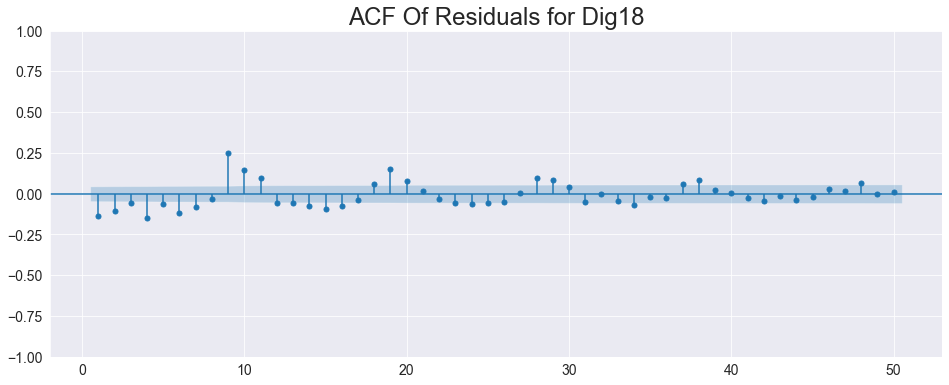

In [22]:
sgt.plot_acf(data18_resid_dataset.residuals, zero = False, lags = 50)
plt.title("ACF Of Residuals for Dig18",size=24)
plt.show()

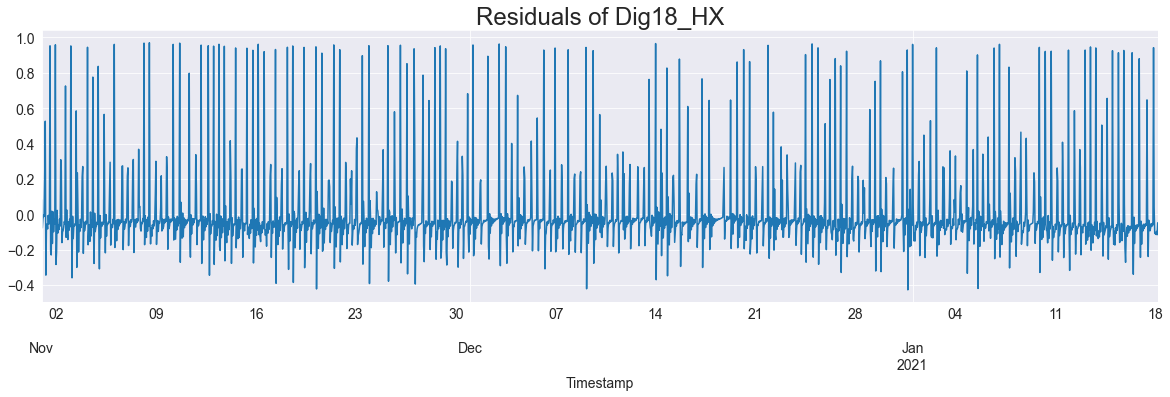

In [23]:
data18_resid_dataset.residuals.plot(figsize=(20,5))
plt.title("Residuals of Dig18_HX",size=24)
plt.show()

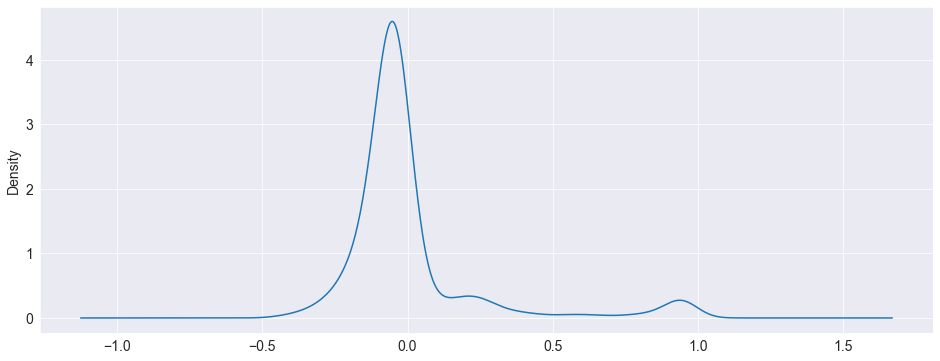

In [24]:
data18_resid_dataset.residuals.plot(kind='kde')
plt.show()

### Model Validation

In [25]:
start_date = "2021-01-18 05:00:00"
end_date = "2021-01-27 08:00:00"

In [26]:
df_pred = pd.DataFrame(model_auto.predict(n_periods = len(val_data18), index = val_data18.index))

In [27]:
scaler2 = MinMaxScaler()
scaler2.fit_transform(data18_twin1.Dig_18_HX.values.reshape(-1, 1))

array([[0.08127673],
       [0.00445627],
       [0.00111094],
       ...,
       [0.00449137],
       [0.00558624],
       [1.        ]])

In [28]:
# Invert the scale of predictions
df_pred2 = scaler2.inverse_transform(df_pred.values.reshape(-1, 1))

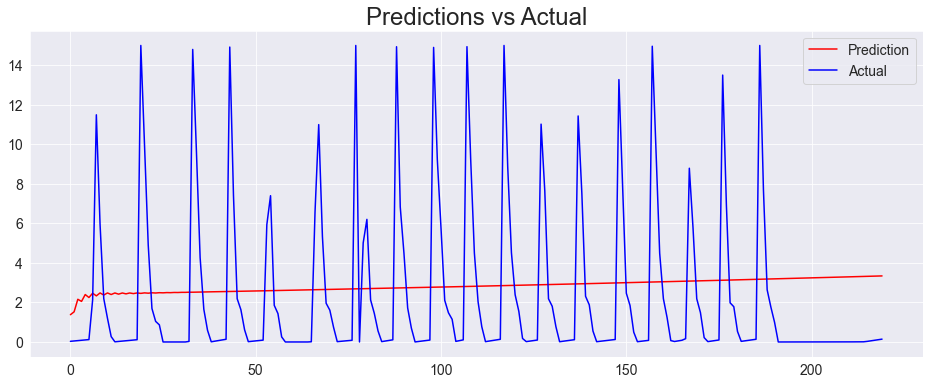

In [29]:
plt.plot(df_pred.index.to_numpy(), df_pred2, color = "red")
plt.plot(df_pred.index, data18_twin1.Dig_18_HX[start_date:end_date].to_numpy(), color = "blue")
plt.legend(['Prediction', 'Actual'])
plt.title("Predictions vs Actual", size = 24)
plt.show()

### Performance Metrics

In [30]:
ndapred, ndaactual = df_pred, val_data18.Dig_18_HX.to_numpy()

In [31]:
print(ndapred.shape)
print(ndaactual.shape)

(220, 1)
(220,)


In [32]:
print("MAE: %.4f" %mean_absolute_error(ndaactual, ndapred))
print("RMSE: %.4f" %np.sqrt(mean_squared_error(ndaactual, ndapred)))

MAE: 0.2156
RMSE: 0.2723


In [33]:
np.save("C:/Users/USER/Documents/PythonModels/Linear/Composite predictions/Dig18pred.npy", df_pred2)

### Forecast

In [34]:
fcast = pd.DataFrame(model_auto.predict(n_periods = len(test_data18), index = test_data18.index))

In [38]:
fcast = scaler2.inverse_transform(fcast.values.reshape(-1, 1))

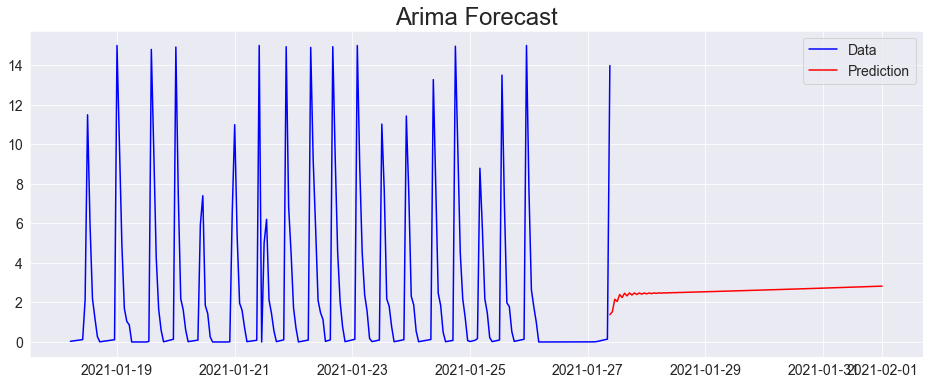

In [39]:
plt.plot(data18_twin1.index[1877:2098], data18_twin1.Dig_18_HX[1877:2098].to_numpy(), color = "blue")
plt.plot(test_data18.index, fcast, color = "red")
plt.legend(['Data', 'Prediction'])
plt.title("Arima Forecast", size = 24)
plt.show()

In [37]:
np.save("C:/Users/USER/Documents/PythonModels/Linear/Composite predictions/Dig18fcast.npy", fcast)